In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cvxpy as cp
from torch.autograd import Function
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')
import time


import warnings
warnings.filterwarnings("ignore")

from myutil import *
from features import *

# Import Data

In [24]:
def load_and_process_data(file_path):
    df = pd.read_csv(file_path)

    columns_to_keep = [
        'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
        'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
        'g_continuous', 'utility_binary', 'utility_continuous'
    ]
    # for race 0 is white, 1 is black
    df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

    all_features = df[get_all_features(df)]
    risk_score = df['risk_score_t']
    g_factor = df['g_continuous']
    decision = df['propensity_score']

    feats = all_features.values
    risk = risk_score.values
    cost = np.ones(risk.shape)
    gainF = g_factor.values
    decision = decision.values

    alpha = 0.5
    Q = 1e2

    data = feats, risk, cost, gainF, decision

    num_data, num_items = risk.shape[0], 1
    utility = risk * gainF * decision
    
    return data, utility

# Usage
file_path = 'data/data.csv'
data, utility = load_and_process_data(file_path)

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cvxpy as cp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class FairnessDataset(Dataset):
    def __init__(self, features, risk, gainF, cost):
        self.features = torch.FloatTensor(features)
        self.risk = torch.FloatTensor(risk)
        self.gainF = torch.FloatTensor(gainF)
        self.cost = torch.FloatTensor(cost)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return (self.features[idx], 
                self.risk[idx], 
                self.gainF[idx], 
                self.cost[idx])

class LinearRiskPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear(x)).squeeze()

class FairnessSolver:
    def __init__(self, Q):
        self.Q = Q
    
    def solve(self, gainF, risk, cost, alpha):
        gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
        d = cp.Variable(risk.shape[0], nonneg=True)
        
        utils = cp.multiply(cp.multiply(gainF, risk), d)
        
        if alpha == 'inf':
            t = cp.Variable()
            objective = cp.Maximize(t)
            constraints = [
                d >= 0,
                d <= 1,
                cp.sum(cost * d) <= self.Q,
                utils >= t
            ]
        else:  # alpha = 0 (linear case)
            objective = cp.Maximize(cp.sum(utils))
            constraints = [
                d >= 0,
                d <= 1,
                cp.sum(cost * d) <= self.Q
            ]
        
        problem = cp.Problem(objective, constraints)
        try:
            problem.solve(solver=cp.SCS, max_iters=2000, verbose=False)
            
            if problem.status != 'optimal':
                print(f"Warning: Problem status is {problem.status}")
                return np.zeros_like(risk), 0.0
                
            return d.value, problem.value
            
        except Exception as e:
            print(f"Optimization failed: {str(e)}")
            return np.zeros_like(risk), 0.0

class FairnessSPOPlus(nn.Module):
    def __init__(self, Q, alpha, reduction="mean"):
        super().__init__()
        self.Q = Q
        self.alpha = alpha
        self.reduction = reduction
        self.solver = FairnessSolver(Q)
    
    def forward(self, pred_risk, true_risk, gainF, cost):
        device = pred_risk.device
        batch_size = pred_risk.shape[0]
        
        
        # Convert all inputs to numpy for solver
        pred_risk_np = pred_risk.detach().cpu().numpy()
        true_risk_np = true_risk.detach().cpu().numpy()
        gainF_np = gainF.cpu().numpy()
        cost_np = cost.cpu().numpy()
        
        # Get true solution
        true_sol, true_obj = self.solver.solve(
            gainF_np,
            true_risk_np,
            cost_np,
            self.alpha
        )
        
        # Get SPO solution (2*pred - true)
        modified_risk_np = 2 * pred_risk_np - true_risk_np
        spo_sol, _ = self.solver.solve(
            gainF_np,
            modified_risk_np,
            cost_np,
            self.alpha
        )
        
        # Convert solutions back to tensors
        true_sol = torch.FloatTensor(true_sol).to(device)
        spo_sol = torch.FloatTensor(spo_sol).to(device)
        modified_risk = torch.FloatTensor(modified_risk_np).to(device)
        
        # Ensure all tensors are on same device
        gainF = gainF.to(device)
        pred_risk = pred_risk.to(device)
        true_risk = true_risk.to(device)
        
        # Compute loss without dimension reduction
        pred_term = gainF * modified_risk * spo_sol
        coupling_term = gainF * pred_risk * true_sol
        true_term = gainF * true_risk * true_sol
        
        # Sum for each sample
        loss = -torch.sum(pred_term) + 2 * torch.sum(coupling_term) - torch.sum(true_term)
        
        # Apply reduction
        if self.reduction == "mean":
            loss = loss / batch_size
        
        return loss

Using device: cuda
Epoch [10/10] - Time: 14.61s
Train Loss: -19.6544, Val Loss: -19.5487, Val MSE: 47.7813


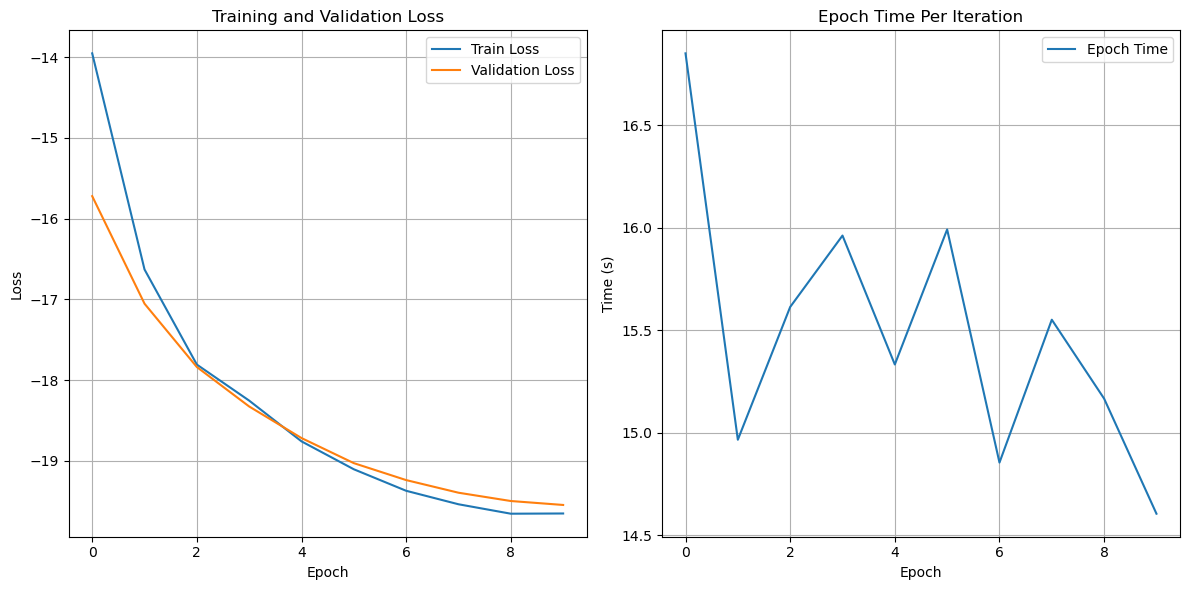

In [30]:
import time

# Updated train_model function to track time and MSE loss
def train_model(features, risk, gainF, cost, Q, alpha='inf', 
                batch_size=32, epochs=100, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_loader, val_loader, (train_idx, val_idx) = prepare_data(
        features, risk, gainF, cost, 
        batch_size=batch_size
    )

    model = LinearRiskPredictor(features.shape[1]).to(device)
    criterion_spo = FairnessSPOPlus(Q=Q, alpha=alpha).to(device)
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'val_mse_loss': [], 'epoch_times': []}
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        train_loss = 0
        for batch_features, batch_risk, batch_gainF, batch_cost in train_loader:
            batch_features = batch_features.to(device)
            batch_risk = batch_risk.to(device)
            batch_gainF = batch_gainF.to(device)
            batch_cost = batch_cost.to(device)

            optimizer.zero_grad()
            pred_risk = model(batch_features)

            loss = criterion_spo(pred_risk, batch_risk, batch_gainF, batch_cost)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0
        val_mse = 0
        with torch.no_grad():
            for batch_features, batch_risk, batch_gainF, batch_cost in val_loader:
                batch_features = batch_features.to(device)
                batch_risk = batch_risk.to(device)
                batch_gainF = batch_gainF.to(device)
                batch_cost = batch_cost.to(device)

                pred_risk = model(batch_features)

                loss = criterion_spo(pred_risk, batch_risk, batch_gainF, batch_cost)
                mse = mse_loss(pred_risk, batch_risk)

                val_loss += loss.item()
                val_mse += mse.item()

        val_loss /= len(val_loader)
        val_mse /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_mse_loss'].append(val_mse)

        epoch_time = time.time() - start_time
        history['epoch_times'].append(epoch_time)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - Time: {epoch_time:.2f}s')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}')

    model.load_state_dict(best_model)
    return model, history, (train_idx, val_idx)

# Plotting both epoch time and training/validation loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history['epoch_times'], label='Epoch Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.title('Epoch Time Per Iteration')
    plt.grid()

    plt.tight_layout()
    plt.show()

# Optimizing DataLoader with multiprocessing
def prepare_data(features, risk, gainF, cost, test_size=0.2, batch_size=32):
    train_idx, val_idx = train_test_split(
        np.arange(len(features)), 
        test_size=test_size, 
        random_state=42
    )

    train_dataset = FairnessDataset(
        features[train_idx], risk[train_idx],
        gainF[train_idx], cost[train_idx]
    )
    val_dataset = FairnessDataset(
        features[val_idx], risk[val_idx],
        gainF[val_idx], cost[val_idx]
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=False)

    return train_loader, val_loader, (train_idx, val_idx)

if __name__ == "__main__":
    # Updated Training Flow
    features = data[0]
    n_samples = features.shape[0]
    n_features = features.shape[1]
    risk = data[1]
    cost = data[2]
    gainF = data[3]
    Q = 1e3

    model, history, (train_idx, val_idx) = train_model(
        features=features,
        risk=risk,
        gainF=gainF,
        cost=cost,
        Q=Q,
        alpha='inf',
        epochs=10,
        batch_size=32,
        lr=0.001
    )

    plot_history(history)
